## **<span style="color:orange;">Import Libraries</span>**

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from feature_engine.transformation import LogTransformer, BoxCoxTransformer, YeoJohnsonTransformer
import math
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
import sklearn
import warnings

In [37]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output='pandas')
warnings.filterwarnings("ignore")

## **<span style="color:orange;">Reading Data</span>**

In [38]:
# Function to read data from source
def get_data():
    BASE_DIR = Path.cwd().parents[0]
    file_name = 'claims-severity-anonymized-raw.csv'
    return pd.read_csv(BASE_DIR / 'data' / 'allstate-claims-severity' / file_name, on_bad_lines="skip")

In [39]:
# Reading data from source
df = get_data()

In [40]:
# Applying Data Cleaning Steps
df = df.dropna(axis=0, ignore_index=True).drop('id', axis=1)

In [41]:
# Preview of data
df.head(5)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [42]:
# List of Categorical Features
cat_cols = df.select_dtypes(include='O').columns.to_list()

# List of Numerical Features
num_cols = df.select_dtypes(include=float).columns.to_list()
num_cols.remove('loss')

print(cat_cols)
print("="*100)
print(num_cols)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

## **<span style="color:orange;">Feature Engineering</span>**
---

### **<span style="color:orange;">Feature Tranformation</span>**

In [43]:
df[num_cols].head(5)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


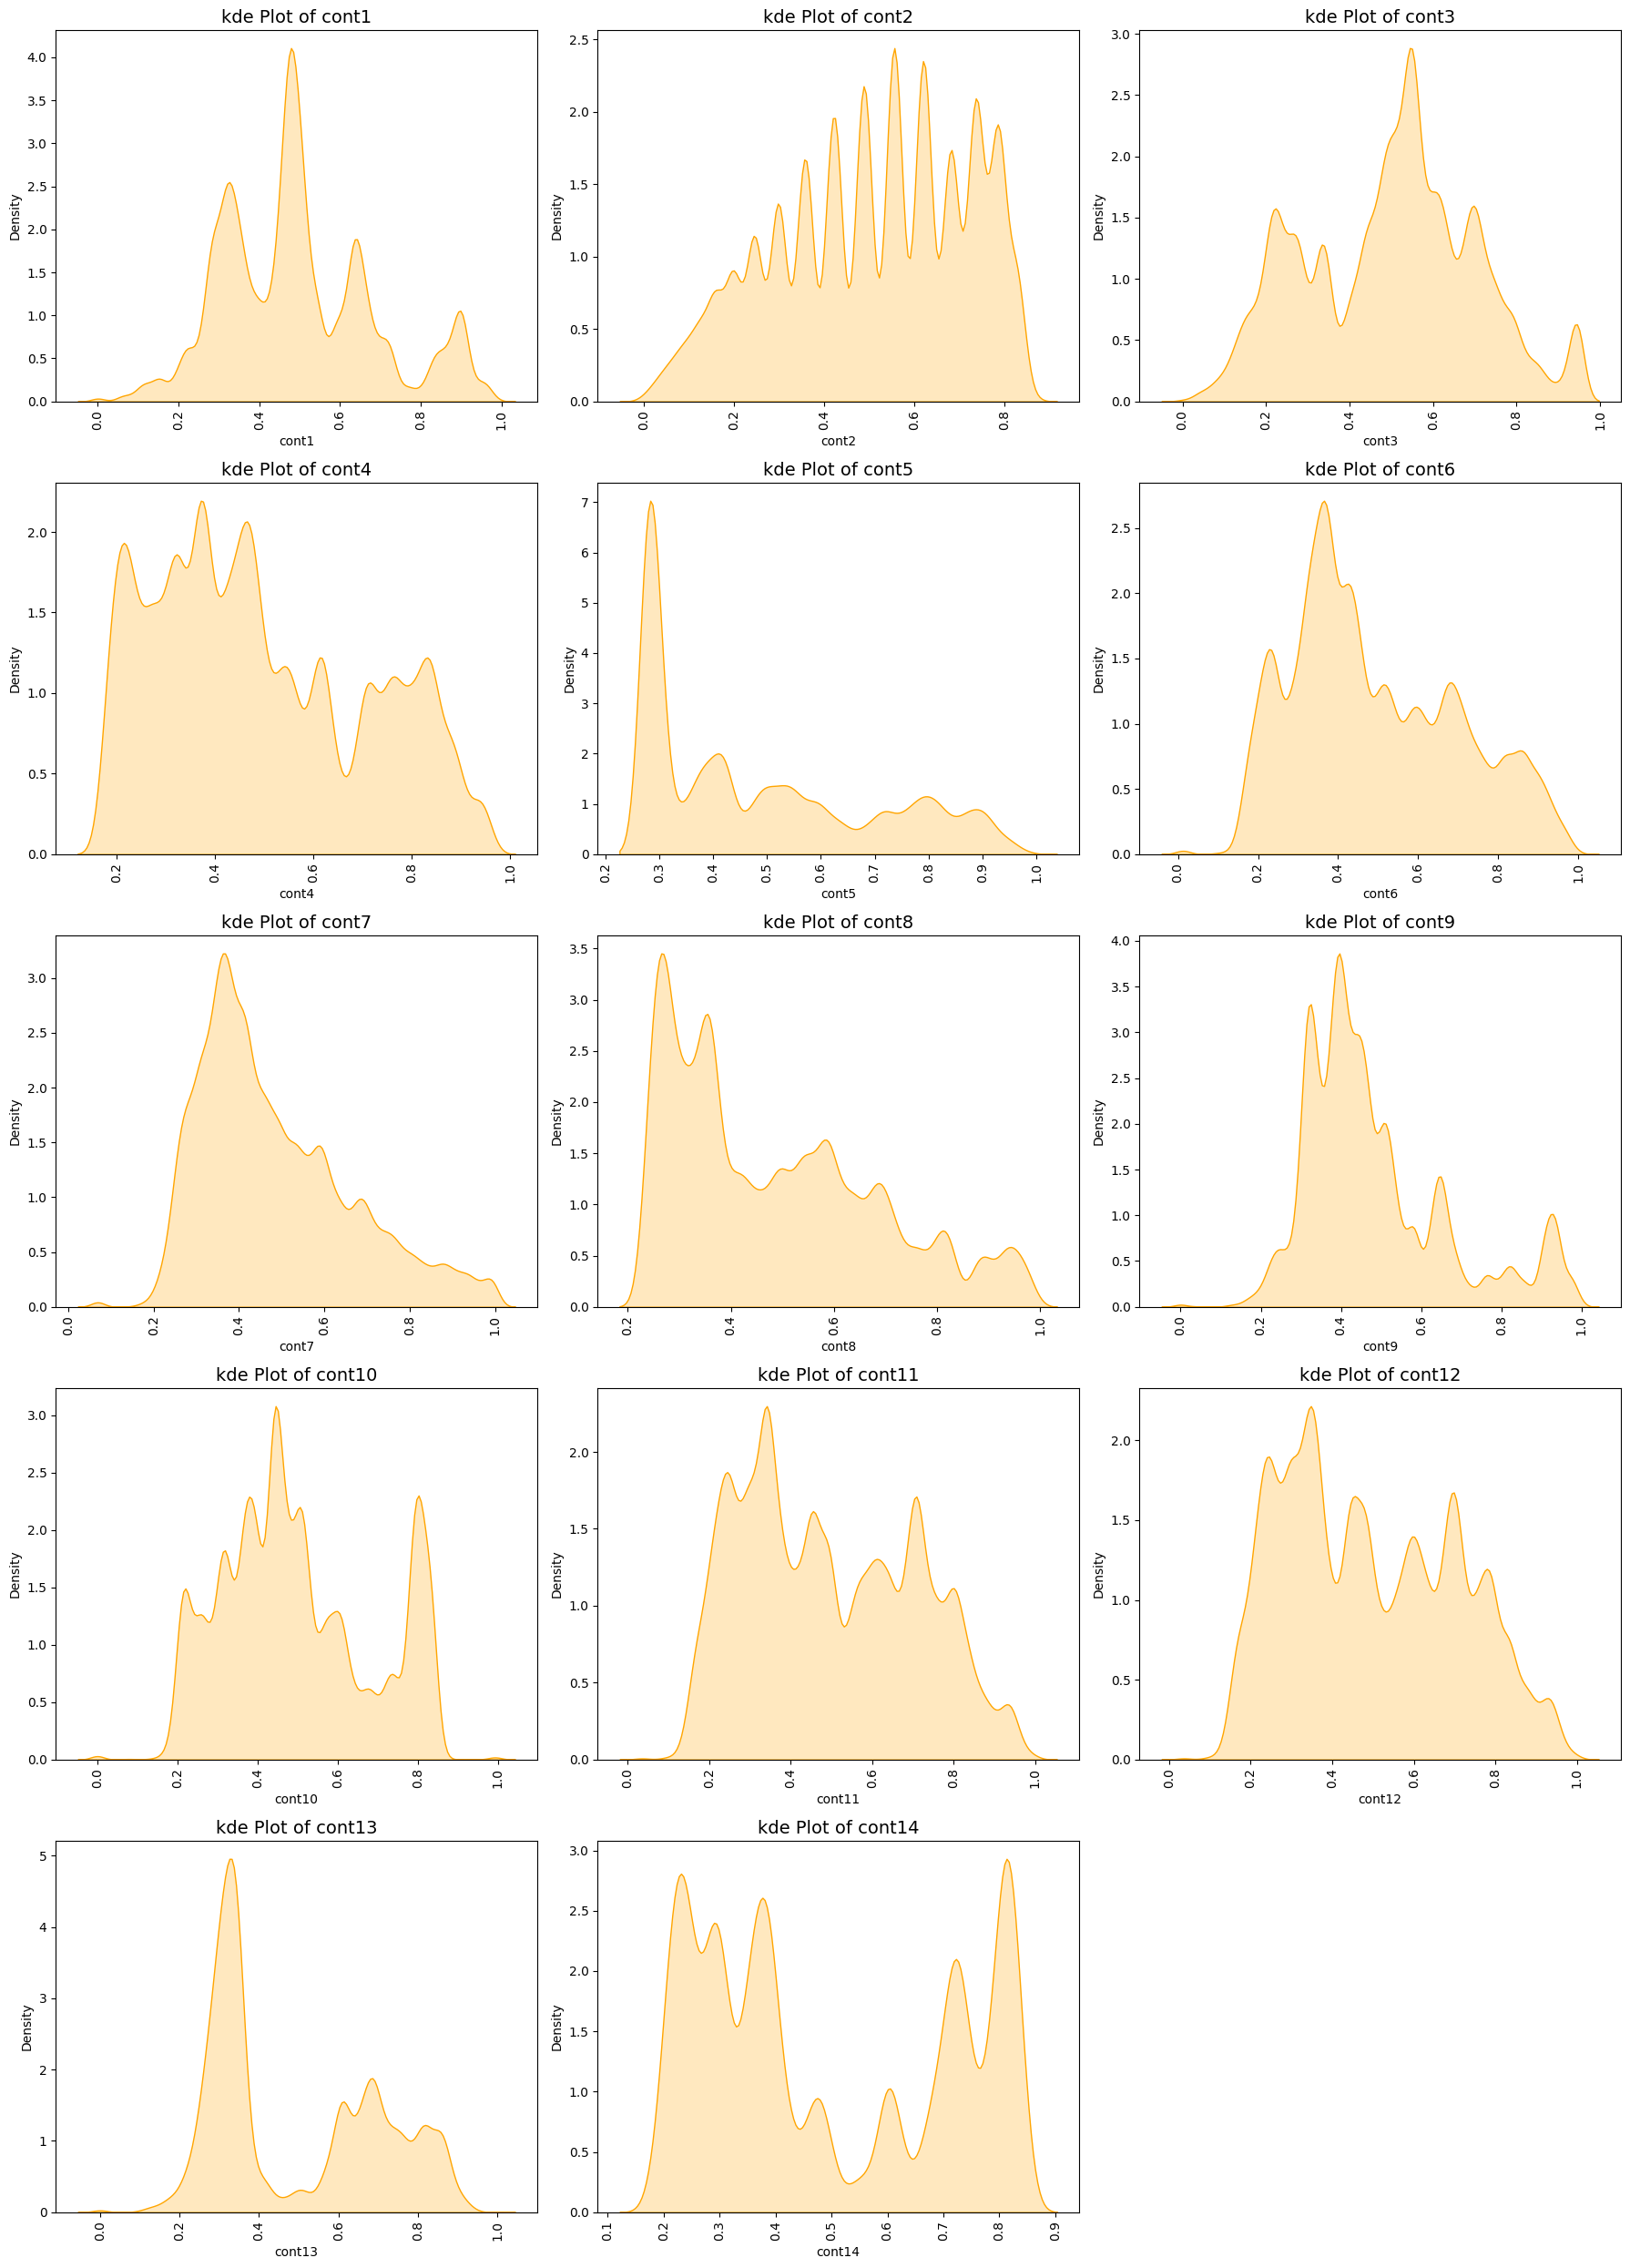

In [44]:
# Kdeplot for numerical features

n_cols = 3
n_rows = math.ceil(len(num_cols)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=df[col],
        color="orange",
        ax=ax,
        fill=True
    )
    ax.set_title(f"kde Plot of {col}", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [45]:
# skewness of numerical feature before any transformations
df[num_cols].skew().to_frame(name="skewness")

,skewness
cont1,0.516424
cont2,-0.310941
cont3,-0.010002
cont4,0.416096
cont5,0.681622
cont6,0.461214
cont7,0.826053
cont8,0.676634
cont9,1.072429
cont10,0.355001


##### <span style="color:orange;">Log1p Transformation</span>

In [46]:
log1p_df = df[num_cols].apply(np.log1p)
log1p_df

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.545980,0.219875,0.171920,0.582014,0.270074,0.541374,0.288976,0.264362,0.513632,0.607099,0.450913,0.466652,0.600205,0.539322
1,0.285565,0.552199,0.465419,0.478799,0.634370,0.363891,0.362269,0.470547,0.301045,0.364080,0.291409,0.312111,0.477123,0.265817
2,0.232572,0.306248,0.394873,0.212628,0.334376,0.254369,0.274251,0.241533,0.231715,0.281005,0.323096,0.317307,0.178739,0.573476
3,0.278839,0.441978,0.423954,0.317592,0.352253,0.365299,0.330115,0.276085,0.278601,0.367881,0.283610,0.278820,0.473172,0.471654
4,0.241537,0.148411,0.423954,0.387438,0.533136,0.163982,0.221068,0.219649,0.199580,0.192519,0.186220,0.184164,0.219947,0.359495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.298179,0.579858,0.478505,0.387438,0.662459,0.217075,0.254603,0.219649,0.268950,0.284690,0.201338,0.198853,0.287651,0.189145
188314,0.410559,0.441978,0.438107,0.589392,0.533136,0.288384,0.323532,0.491490,0.339717,0.390548,0.268215,0.263841,0.276605,0.266871
188315,0.395057,0.579858,0.583543,0.173228,0.393687,0.297050,0.315200,0.219649,0.377121,0.390548,0.368534,0.366983,0.292105,0.408054
188316,0.363521,0.352203,0.261577,0.324564,0.293075,0.533192,0.446521,0.300008,0.369955,0.431009,0.622216,0.616733,0.503652,0.543316


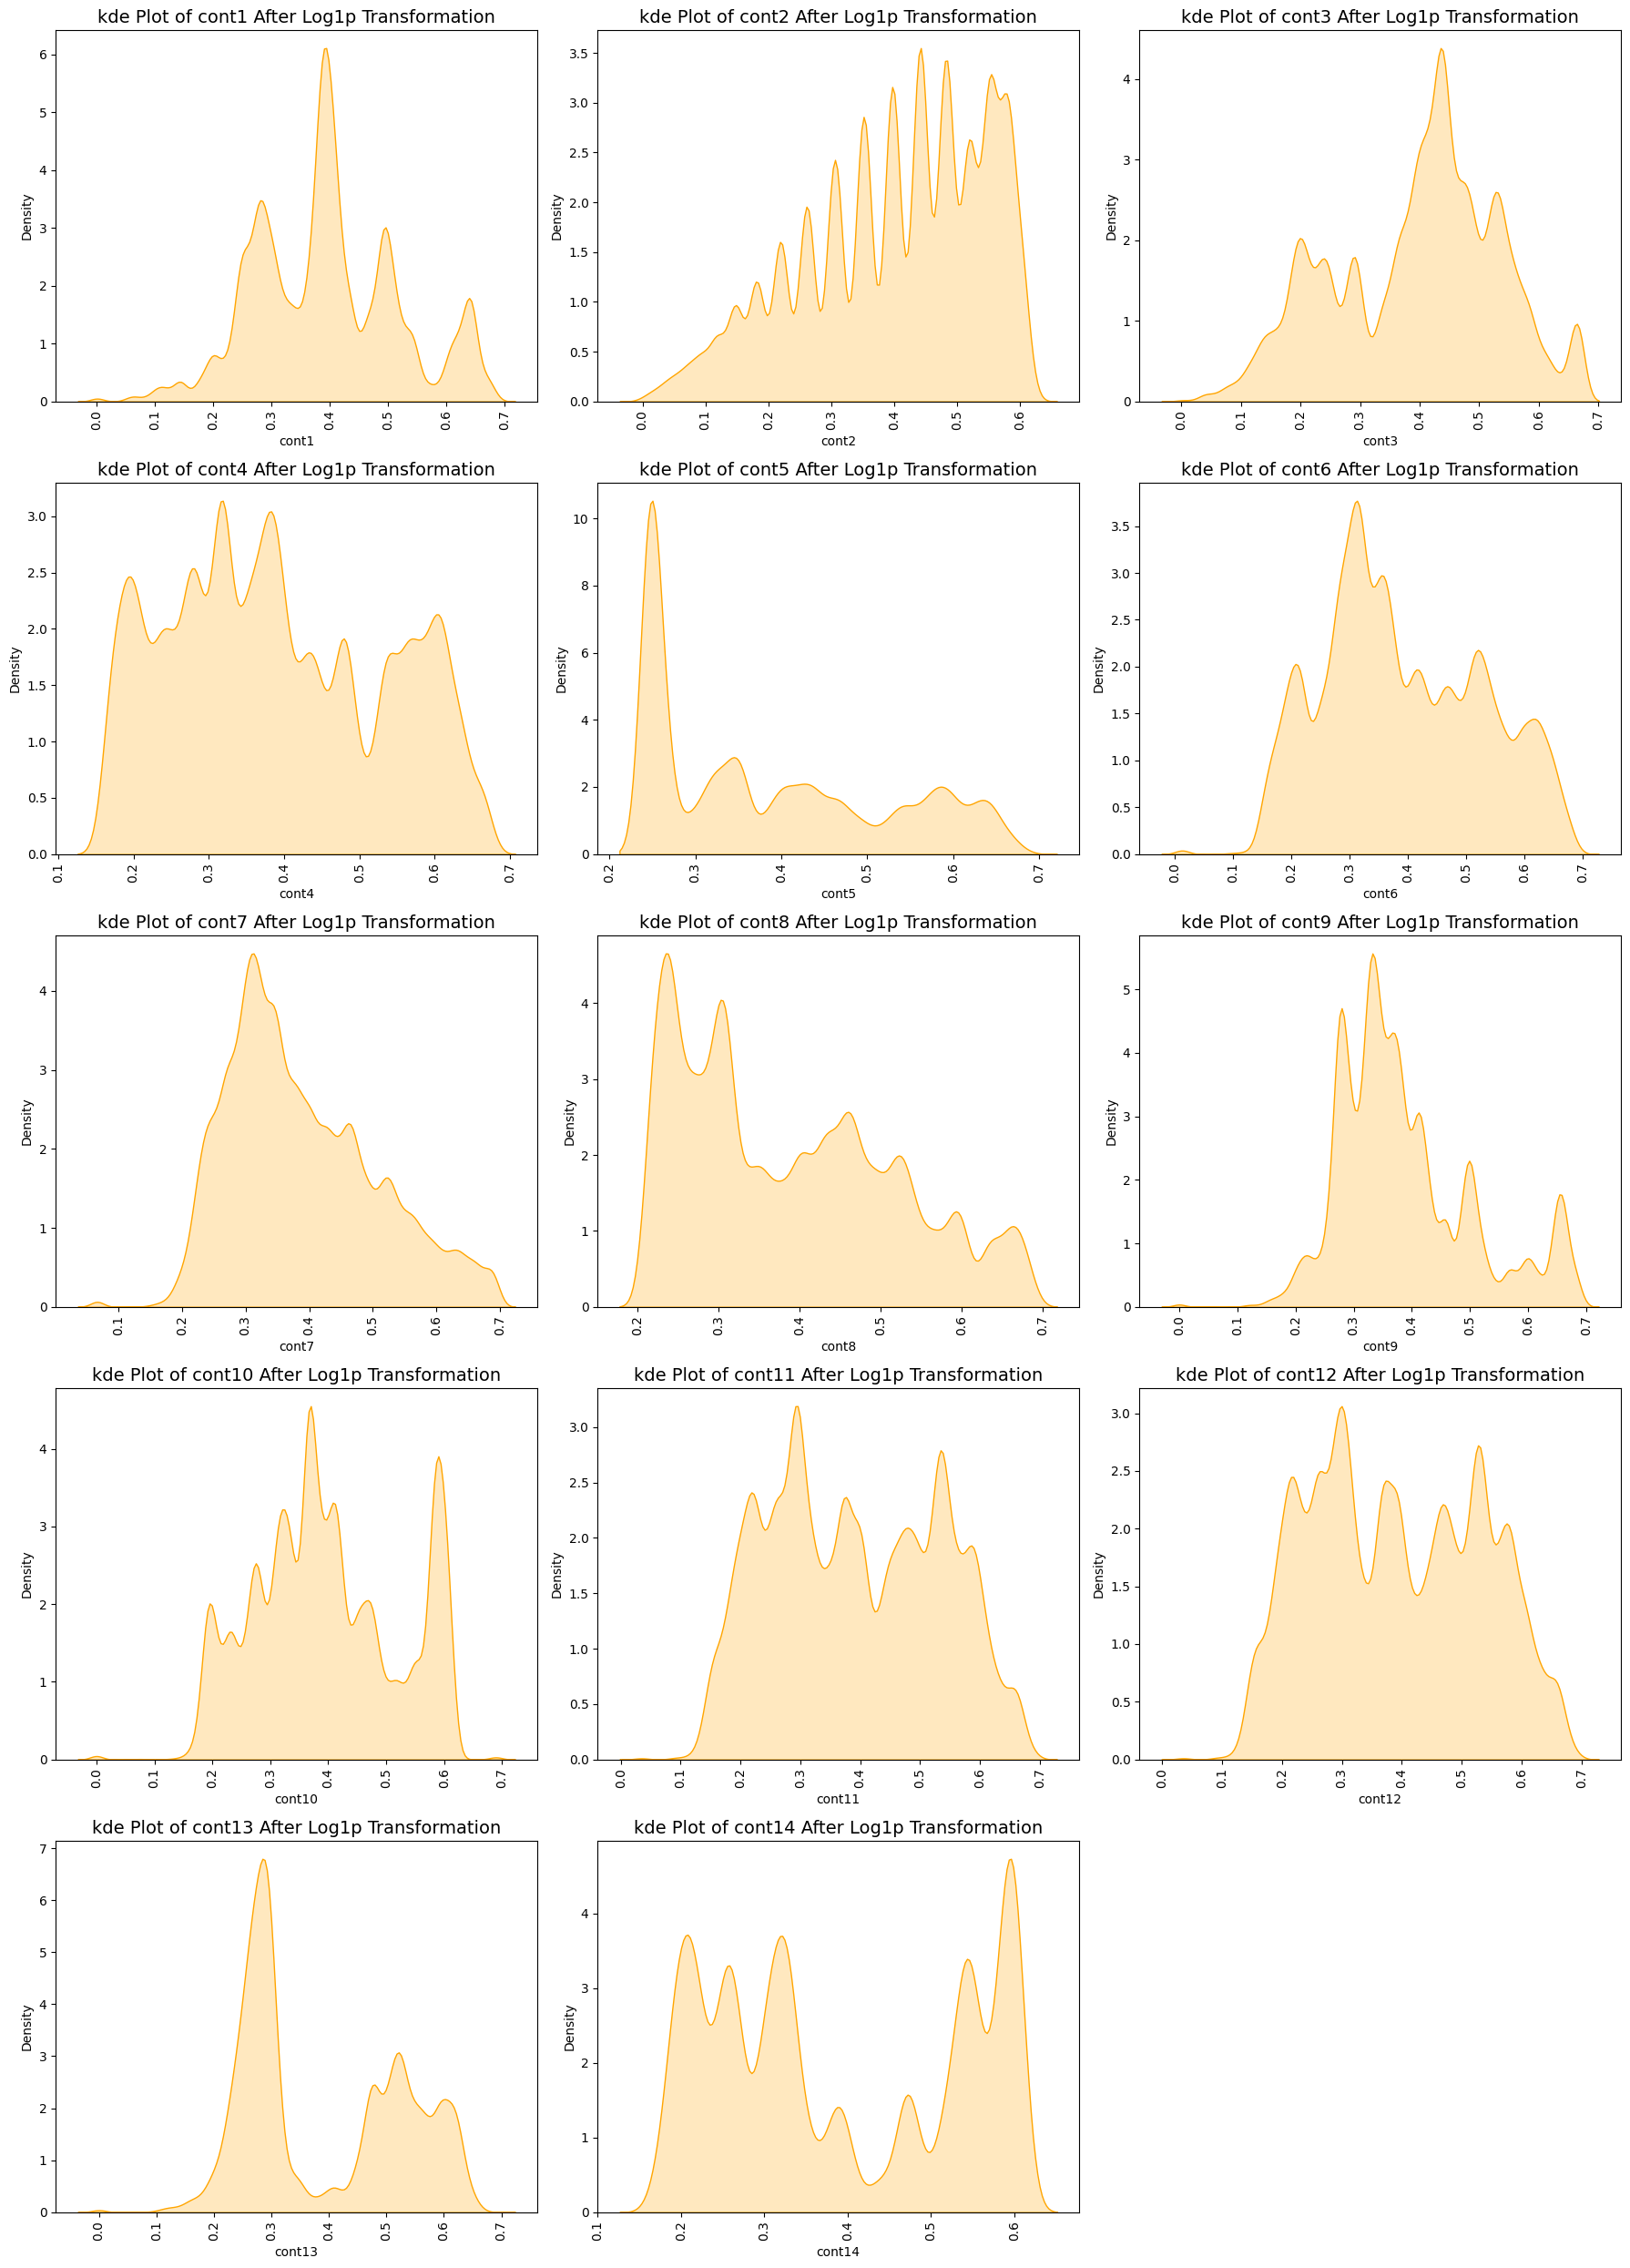

In [47]:
# Kdeplot for numerical features after Log1p transformation

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=log1p_df[col],
        color="orange",
        ax=ax,
        fill=True
    )
    ax.set_title(f"kde Plot of {col} After Log1p Transformation", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [48]:
# skewness of numerical feature after log1p transformations
log1p_df[num_cols].skew().to_frame(name="skewness")

,skewness
cont1,0.201999
cont2,-0.537001
cont3,-0.284624
cont4,0.234676
cont5,0.552307
cont6,0.249939
cont7,0.593133
cont8,0.492940
cont9,0.814233
cont10,0.155137


##### <span style="color:orange;">Yeo-Johnson Transformation</span>

In [49]:
yeo_johnson_df = YeoJohnsonTransformer(variables=num_cols).fit_transform(df[num_cols])
yeo_johnson_df

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.466582,0.276297,0.186527,0.442053,0.184779,0.422382,0.211609,0.198293,0.284491,0.505594,0.409230,0.418958,0.399444,0.428664
1,0.262748,1.010093,0.583282,0.381069,0.282758,0.307220,0.246518,0.287974,0.209284,0.325783,0.273601,0.290269,0.343408,0.236808
2,0.217282,0.422817,0.477742,0.191682,0.210680,0.225740,0.203864,0.185503,0.174384,0.257807,0.301304,0.294749,0.157276,0.449517
3,0.257055,0.710989,0.520405,0.272391,0.217033,0.308213,0.231919,0.204605,0.198663,0.328809,0.266724,0.261300,0.341437,0.385437
4,0.225074,0.172845,0.520405,0.321620,0.265262,0.151747,0.173619,0.172598,0.155964,0.181434,0.178837,0.176408,0.188063,0.307822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.273361,1.096108,0.603638,0.321620,0.286738,0.195985,0.193115,0.172598,0.193903,0.260898,0.192727,0.189831,0.234783,0.174132
188314,0.364505,0.710989,0.541593,0.446177,0.265262,0.251968,0.228796,0.294932,0.226203,0.346711,0.253079,0.248116,0.227474,0.237641
188315,0.352290,1.096108,0.776383,0.159149,0.230506,0.258514,0.224775,0.172598,0.241035,0.346711,0.340364,0.337038,0.237698,0.342375
188316,0.327091,0.511747,0.296384,0.277460,0.194626,0.417493,0.280057,0.216973,0.238304,0.378047,0.544729,0.535288,0.356354,0.431136


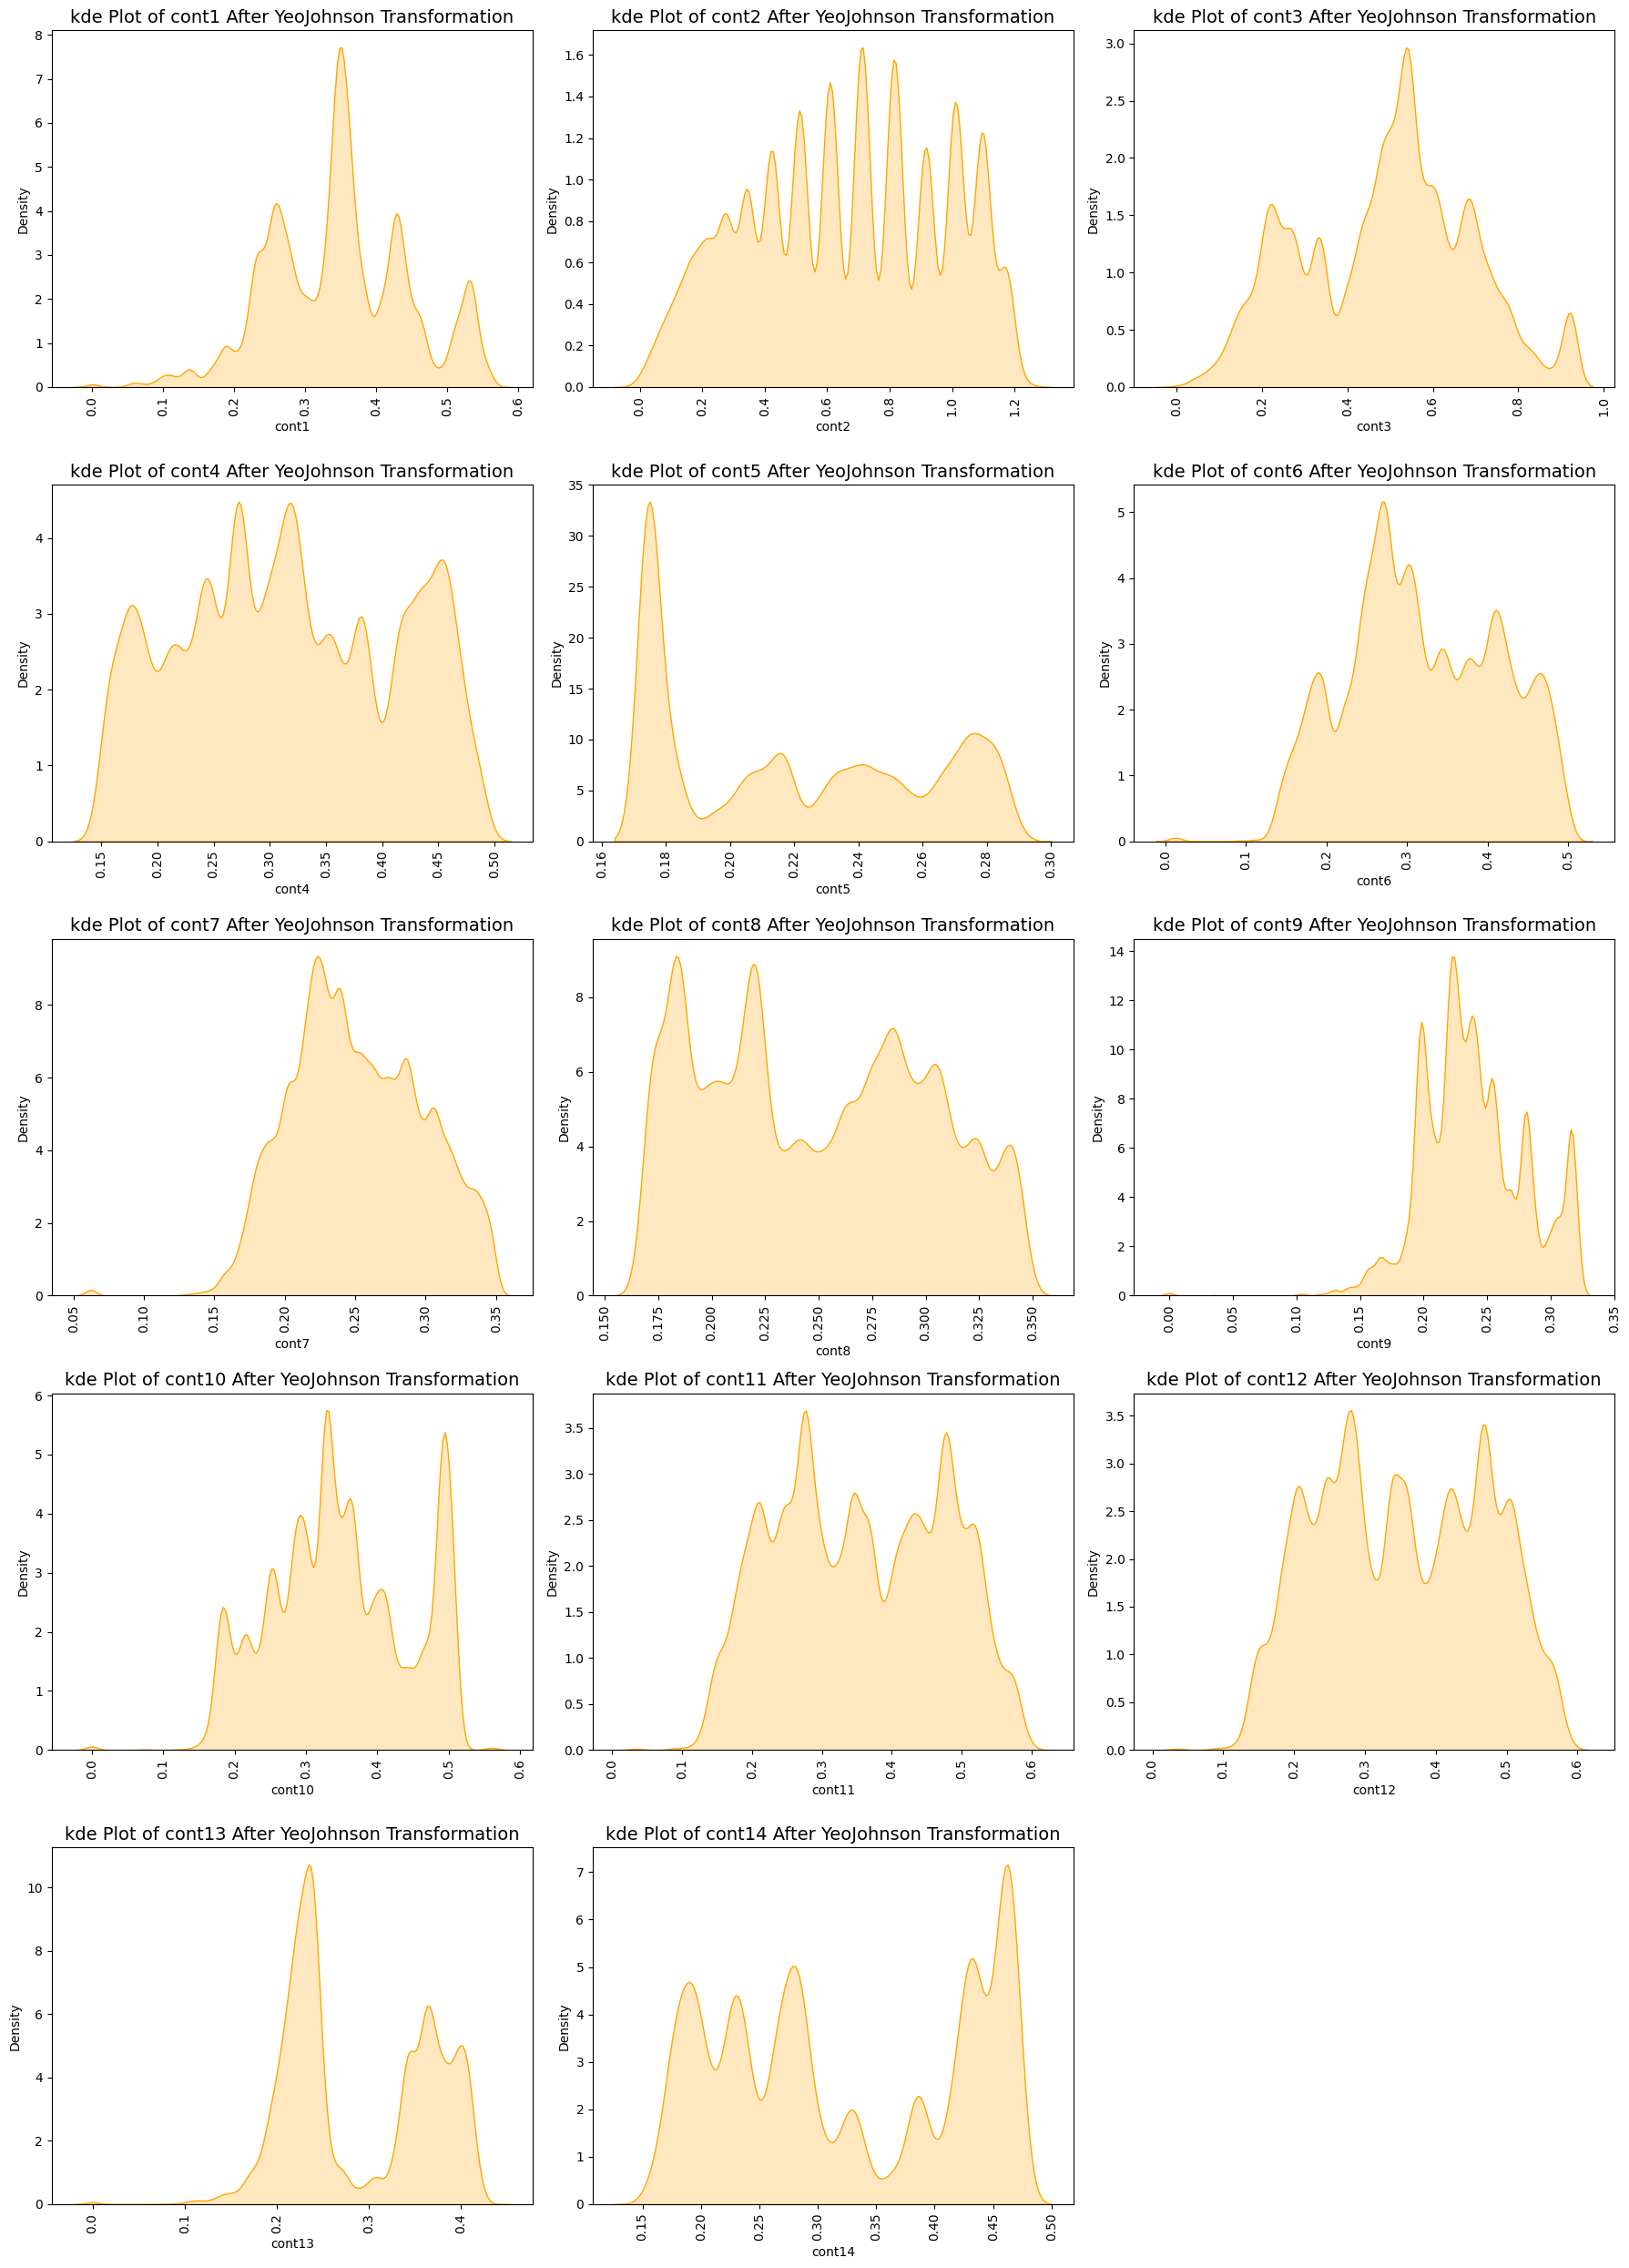

In [50]:
# Kdeplot for numerical features after YeoJohnson transformation

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=yeo_johnson_df[col],
        color="orange",
        ax=ax,
        fill=True
    )
    ax.set_title(f"kde Plot of {col} After YeoJohnson Transformation", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [51]:
yeo_johnson_df[num_cols].skew().to_frame(name="skewness")

,skewness
cont1,0.003913
cont2,-0.102177
cont3,-0.027912
cont4,0.051768
cont5,0.205931
cont6,0.038876
cont7,0.054278
cont8,0.124675
cont9,-0.012653
cont10,0.020272


📌 Effect of Transformations on Numerical Feature Skewness

The original numerical features (cont1–cont14) exhibit mild to moderate skewness, with skewness values ranging from −0.31 to 1.07. Most variables are slightly right-skewed, while a few are near-symmetric, indicating moderate deviation from normality across the numerical feature set.

After applying the **log1p transformation**, a noticeable reduction in skewness is observed for the majority of features. Several variables move closer to symmetry, particularly those with initially higher positive skewness. However, some features retain moderate skewness, and a few become more negatively skewed, suggesting that log1p partially normalizes the distributions but does not fully eliminate asymmetry across all numerical variables.

In contrast, the **Yeo–Johnson transformation** results in a substantial and consistent reduction in skewness across all numerical features. Post-transformation skewness values are tightly centered around zero, with most features exhibiting skewness within ±0.10 and none showing pronounced asymmetry. This indicates that the Yeo–Johnson transformation is more effective in producing approximately symmetric distributions across the entire numerical feature set.

Overall, the comparative analysis demonstrates that while log1p improves distributional symmetry to a certain extent, the Yeo–Johnson transformation achieves a more uniform and near-normal distribution across numerical features.

##### <span style="color:orange;">Outlier Treatment</span>

In [52]:
# To count the number of ouliers in each numerical skewed feature
def iqr_outlier_counts(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3-q1

    lower = q1 - k * iqr_val
    upper = q3 + k * iqr_val

    below = (series < lower).sum()
    above = (series > upper).sum()

    return below, above

In [53]:
outlier_rows = []

for col in num_cols:
    below, above = iqr_outlier_counts(df[col])
    outlier_rows.append({
        "feature": col,
        "below_count": below,
        "above_count": above,
        "total_outliers": below + above
    })

outlier_df = pd.DataFrame(outlier_rows)
outlier_df

,feature,below_count,above_count,total_outliers
0,cont1,0,0,0
1,cont2,0,0,0
2,cont3,0,0,0
3,cont4,0,0,0
4,cont5,0,0,0
5,cont6,0,0,0
6,cont7,0,2659,2659
7,cont8,0,0,0
8,cont9,206,12988,13194
9,cont10,0,140,140


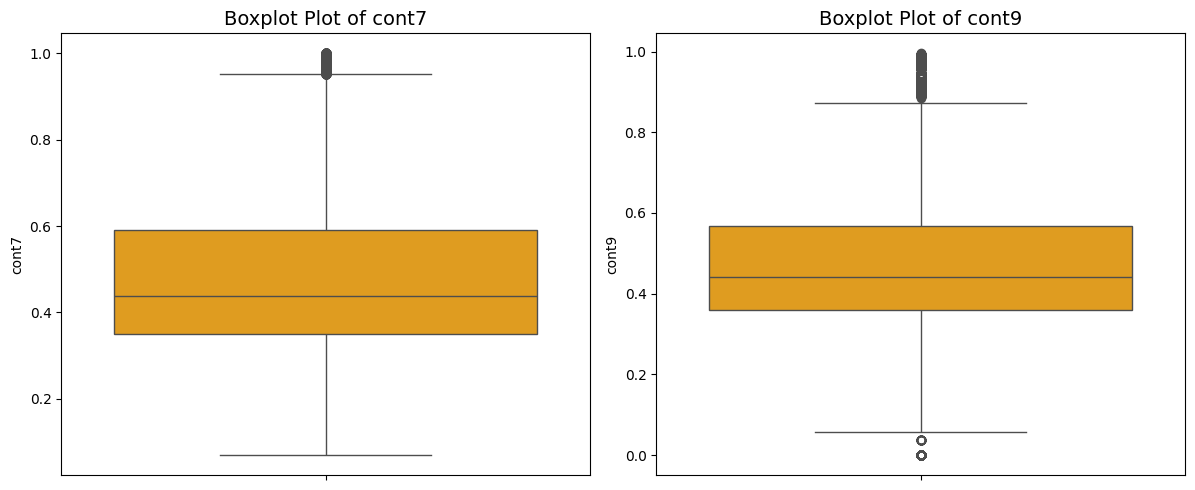

In [54]:
# Plotting Boxplot of numerical features with Outliers
outlier_col = ['cont7', 'cont9']

n_cols = 3
n_rows = math.ceil(len(outlier_col)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, outlier_col):
    sns.boxplot(
        data=df,
        y=col,
        color="orange",
        ax=ax,
    )
    ax.set_title(f"Boxplot Plot of {col}", fontsize=14)
    ax.set_ylabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(outlier_col):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [55]:
winsor = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=outlier_col
)

df_after_winsor = winsor.fit_transform(df)

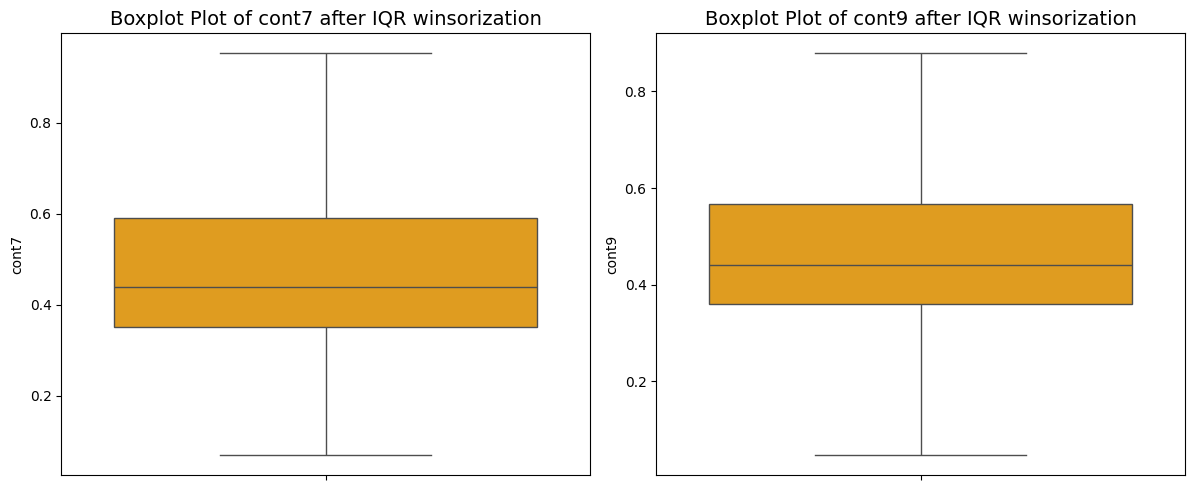

In [56]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, outlier_col):
    sns.boxplot(
        data=df_after_winsor,
        y=col,
        color="orange",
        ax=ax,
    )
    ax.set_title(f"Boxplot Plot of {col} after IQR winsorization", fontsize=14)
    ax.set_ylabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(outlier_col):]:
    ax.remove()

plt.tight_layout()
plt.show()

📌 Outlier Treatment for Skewed Features

When numerical features exhibit skewed distributions, outlier detection methods based on the mean and standard deviation (such as Z-score or ±3 standard deviation rules) become unreliable. This is because skewed data violates the assumption of symmetry around the mean, causing these methods to either miss true outliers or incorrectly flag valid observations.

In such cases, the Interquartile Range (IQR) method is more appropriate. The IQR is a robust, distribution-free measure that relies on the median and quartiles rather than the mean, making it well-suited for skewed data. By focusing on the spread of the middle 50% of the data, the IQR method effectively identifies extreme values without being distorted by skewness or long tails.

In contrast, methods like Z-score or ±3σ are more suitable when features follow an approximately normal distribution, where the mean and standard deviation are stable and representative.

### **<span style="color:orange;">Feature Selection</span>**

##### <span style="color:orange;">Train-Test Split</span>

In [62]:
X = df.drop(
    'loss',
    axis=1
)

y = df.loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [80]:
from feature_engine.selection import (
    DropConstantFeatures,
    DropCorrelatedFeatures,
)

from sklearn.feature_selection import (
    mutual_info_regression
)

In [64]:
constant_feature = DropConstantFeatures(
    tol=0.99,
    missing_values='raise'
)

In [65]:
constant_feature.fit_transform(X_train, y_train)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat36,cat37,cat38,cat39,cat40,cat41,cat43,cat44,cat45,cat49,cat50,cat52,cat53,cat54,cat57,cat65,cat66,cat71,cat72,cat73,cat74,cat75,cat76,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
99992,A,B,A,B,A,A,A,A,B,B,B,B,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,A,C,B,D,B,A,A,A,A,A,C,D,C,E,A,D,T,A,L,A,A,G,F,F,I,K,BI,CL,E,S,AD,A,N,HQ,0.644094,0.785784,0.745801,0.761209,0.397069,0.767863,0.651337,0.94012,0.64103,0.80218,0.745820,0.753252,0.717751,0.677820
1423,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,B,A,A,A,A,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,B,E,E,E,A,S,K,A,A,A,D,E,K,J,I,AB,CS,A,T,BC,J,N,CK,0.249700,0.358319,0.592681,0.688173,0.281143,0.235169,0.314608,0.53642,0.30859,0.35434,0.199654,0.214808,0.476684,0.196693
60934,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,C,A,P,I,A,A,C,E,F,J,G,B,BI,CL,A,AH,BN,A,K,FC,0.376862,0.785784,0.506105,0.442784,0.950364,0.257876,0.303438,0.49462,0.34555,0.35944,0.341813,0.335036,0.318646,0.237818
55805,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,B,A,B,A,B,B,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,A,A,P,K,A,A,A,F,F,G,F,D,BI,BT,A,E,AT,J,K,HC,0.478678,0.159990,0.527991,0.309621,0.364322,0.458113,0.892198,0.45883,0.48950,0.40131,0.535044,0.523266,0.304350,0.823709
115595,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,D,D,A,D,C,B,B,B,A,A,A,A,A,C,D,D,E,E,A,P,G,A,A,B,D,E,J,G,B,BI,CS,A,AI,AE,A,K,CK,0.312802,0.737068,0.711159,0.412789,0.302678,0.220686,0.289239,0.27797,0.38249,0.31003,0.245410,0.241676,0.298734,0.349985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60871,A,B,A,A,A,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,D,D,B,B,C,B,B,D,A,A,A,A,A,D,D,C,E,A,A,D,H,Q,A,A,K,J,F,E,A,BI,CO,A,AM,Q,A,I,MD,0.597726,0.737068,0.440642,0.789639,0.372405,0.505057,0.430767,0.25461,0.58325,0.66572,0.923868,0.916711,0.315758,0.833364
13742,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,D,D,B,B,A,B,B,B,A,A,A,G,H,D,B,E,E,E,A,S,N,A,A,B,E,E,J,K,I,AB,CO,A,AH,N,A,O,DJ,0.218540,0.555782,0.397983,0.524230,0.413817,0.323627,0.298351,0.34987,0.31945,0.22755,0.275431,0.270746,0.503333,0.254329
22100,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,D,B,B,B,C,B,B,B,A,A,A,B,A,D,B,D,E,A,A,P,J,A,A,C,H,F,E,D,D,BI,CL,A,AV,AY,A,I,KJ,0.699001,0.100099,0.397983,0.642745,0.281143,0.577059,0.722138,0.39455,0.53774,0.59869,0.644013,0.630853,0.268941,0.321148
125290,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,D,D,B,B,C,B,D,B,D,A,A,A,A,D,B,C,E,A,C,T,B,A,A,A,K,E,E,H,G,BI,EG,E,E,L,A,P,LM,0.936238,0.422197,0.263570,0.705434,0.281143,0.924590,0.696299,0.88451,0.96909,0.82889,0.757468,0.772574,0.872138,0.803221


In [76]:
print(constant_feature.features_to_drop_)

['cat15', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat32', 'cat33', 'cat34', 'cat35', 'cat42', 'cat46', 'cat47', 'cat48', 'cat51', 'cat55', 'cat56', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat67', 'cat68', 'cat69', 'cat70', 'cat77', 'cat78']


In [77]:
corr_features = DropCorrelatedFeatures(
    missing_values='raise'
)

In [78]:
corr_features.fit_transform(X_train, y_train)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont7,cont8,cont11,cont13,cont14
99992,A,B,A,B,A,A,A,A,B,B,B,B,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,D,B,B,A,A,C,B,D,B,A,A,A,A,A,C,D,C,E,A,D,T,A,L,A,A,G,F,F,I,K,BI,CL,E,S,AD,A,N,HQ,0.644094,0.785784,0.745801,0.761209,0.397069,0.651337,0.94012,0.745820,0.717751,0.677820
1423,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,B,E,E,E,A,S,K,A,A,A,D,E,K,J,I,AB,CS,A,T,BC,J,N,CK,0.249700,0.358319,0.592681,0.688173,0.281143,0.314608,0.53642,0.199654,0.476684,0.196693
60934,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,C,A,P,I,A,A,C,E,F,J,G,B,BI,CL,A,AH,BN,A,K,FC,0.376862,0.785784,0.506105,0.442784,0.950364,0.303438,0.49462,0.341813,0.318646,0.237818
55805,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,D,B,B,B,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,A,A,P,K,A,A,A,F,F,G,F,D,BI,BT,A,E,AT,J,K,HC,0.478678,0.159990,0.527991,0.309621,0.364322,0.892198,0.45883,0.535044,0.304350,0.823709
115595,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,B,D,D,A,D,C,B,B,B,A,A,A,A,A,C,D,D,E,E,A,P,G,A,A,B,D,E,J,G,B,BI,CS,A,AI,AE,A,K,CK,0.312802,0.737068,0.711159,0.412789,0.302678,0.289239,0.27797,0.245410,0.298734,0.349985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60871,A,B,A,A,A,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,D,D,D,B,B,C,B,B,D,A,A,A,A,A,D,D,C,E,A,A,D,H,Q,A,A,K,J,F,E,A,BI,CO,A,AM,Q,A,I,MD,0.597726,0.737068,0.440642,0.789639,0.372405,0.430767,0.25461,0.923868,0.315758,0.833364
13742,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,B,D,D,B,B,A,B,B,B,A,A,A,G,H,D,B,E,E,E,A,S,N,A,A,B,E,E,J,K,I,AB,CO,A,AH,N,A,O,DJ,0.218540,0.555782,0.397983,0.524230,0.413817,0.298351,0.34987,0.275431,0.503333,0.254329
22100,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,B,B,B,C,B,B,B,A,A,A,B,A,D,B,D,E,A,A,P,J,A,A,C,H,F,E,D,D,BI,CL,A,AV,AY,A,I,KJ,0.699001,0.100099,0.397983,0.642745,0.281143,0.722138,0.39455,0.644013,0.268941,0.321148
125290,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,

In [79]:
print(corr_features.features_to_drop_)

['cont10', 'cont9', 'cont12', 'cont6']
